# Sea-Ice Detection with Micron Sonar

In [545]:
# import external libraries
import csv
import datetime
import dateutil
import dill
import importlib
import pandas as pd
import plotly.express as px
import math
import numpy as np
import os
import seaborn as sns 
import sys
from PIL import Image
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import micron_plotter
import MicronSonar
import MicronEnsemble
import MicronTimeSeries

# use Seaborn settings for plotting 
sns.set()

---
## 0. Reload Modules and Initialize Data Dictionary

In [546]:
def reload_modules():
    importlib.reload(MicronSonar)
    importlib.reload(MicronEnsemble)
    importlib.reload(MicronTimeSeries)
    importlib.reload(micron_plotter)

In [547]:
# # load labeled data settings from saved file to use previous settings 
# labeled_data_time_series = {}
# labeled_data_settings    = {}

# with open('labeled_data_settings', 'rb') as pickle_file:
#     labeled_data_settings = dill.load(pickle_file)

---
## 1. Parse Micron Sonar file

In [721]:
reload_modules()

#############################################
# STEP 1: set file ##########################
file     = "Fri_24_Jan_14_04"
ext      = ".CSV"


#############################################
# STEP 2: set folder ########################
folder   = "2020-01-24_WHOI-Tank/csv/"
# folder   = "2020-02-10_Saint-Fabien-Day1/csv/"
# folder   = "2020-02-11_Saint-Fabien-Day2/csv/"
# folder   = "2020-02-12_Saint-Fabien-Day3/csv/"
# folder   = "2020-02-13_Saint-Fabien-Day4/csv/"
root     = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/Micron Sonar/"
filepath = "%s%s%s%s" % (root, folder, file, ext)


#############################################
# STEP 3: set date, depth, altitude #########
date     = (2020, 1, 24)
# date     = (2020, 2, 13)
constant_depth = None
constant_altitude = None


#############################################
# STEP 4: parse file ########################
ts = MicronTimeSeries.MicronTimeSeries.from_raw_csv(
    filepath, 
    date=date,
    bearing_bias=0,
    constant_depth=constant_depth,
    constant_altitude=constant_altitude
)

Parsing: Fri_24_Jan_14_04
  >> Ensembles Parsed:   100
  >> Ensembles Parsed:   200
  >> Ensembles Parsed:   300
  >> Ensembles Parsed:   400
  >> Ensembles Parsed:   500
  >> Ensembles Parsed:   600
  >> Ensembles Parsed:   700
  >> Ensembles Parsed:   800
  >> Ensembles Parsed:   900
  >> Ensembles Parsed:  1000
  >> Ensembles Parsed:  1100
  >> Ensembles Parsed:  1200
  >> Ensembles Parsed:  1300
  >> Ensembles Parsed:  1400
  >> Ensembles Parsed:  1500
  >> Ensembles Parsed:  1600
  >> Ensembles Parsed:  1700
  >> Ensembles Parsed:  1800
  >> Ensembles Parsed:  1900
  >> Ensembles Parsed:  2000
  >> Ensembles Parsed:  2100
  >> Ensembles Parsed:  2200
  >> Ensembles Parsed:  2300
  >> Ensembles Parsed:  2400
  >> Finished Parsing!


---
## 2. Crop Micron Sonar File

In [ ]:
left_limit  = -60
right_limit =  60
ts_cropped  = ts.crop_on_bearing(left_limit, right_limit)
ts_swath    = ts.crop_on_bearing(left_limit, right_limit, single_swath=True)

---
## 3. Define Separator and Set Ice Labels Appropriately

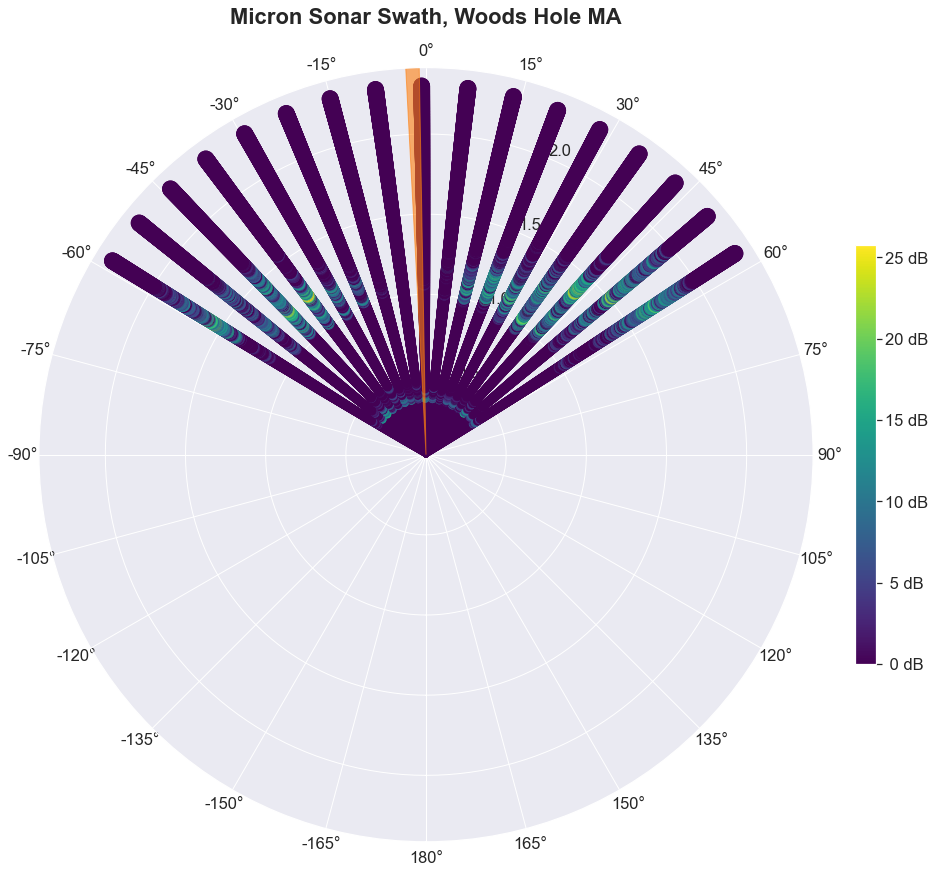

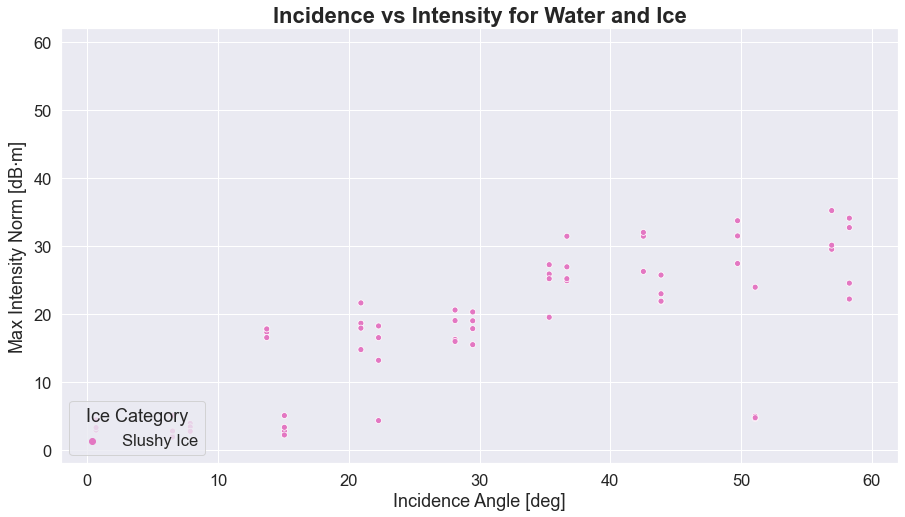

In [513]:
reload_modules()
make_polar_plot     = True
make_incidence_plot = True
# make_polar_plot     = False
# make_incidence_plot = False


#############################################
# STEP 1: set separator #####################
min_bearing = -180
max_bearing =  180
separator   = -2.0
pad         =  1.0


#############################################
# STEP 2: generate plot #####################
if make_polar_plot:
    micron_plotter.plot_polar(ts_swath, 
                              separator=separator, 
                              pad=pad,
                              output_file=ts_swath.name+"_polar",
                              plot_depth = None)
"""
#############################################
# Labels to Consider ########################
    'label_ice_category',   # user specified label  for ice-category
    'label_ice_presence',   # user specified label  for ice-presence
    'label_ice_percent',    # user specified label  for ice-percentage
    'label_ice_thickness',  # user specified label  for ice-thickness 
    'label_ice_slope',      # user specified label  for ice-slope
    'label_ice_roughness',  # user specified label  for ice-roughness
    'label_saltwater_flag'  # value 1 means saltwater, 0 freshwater
"""


#############################################
# STEP 3: write labels ######################
labels = [
    
#     # Eel Pond open water 
#     ('label_ice_category',    0, min_bearing, max_bearing,  pad),
#     ('label_ice_presence',    0, min_bearing, max_bearing,  pad),
#     ('label_ice_percent',     0, min_bearing, max_bearing,  pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,  pad)
    
    
#     # Blake Tank Test
#     # open water side 
#     ('label_ice_category',   10, min_bearing, separator,   pad),
#     ('label_ice_presence',    1, min_bearing, separator,   pad),
#     ('label_ice_percent', 0.883, min_bearing, separator,   pad),
#     ('label_saltwater_flag',  0, min_bearing, max_bearing, 0),
#     ('label_ice_category',    0, min_bearing, separator,   pad),
#     ('label_ice_presence',    0, min_bearing, separator,   pad),
#     ('label_ice_percent',     0, min_bearing, separator,   pad),
#     # ice slab side
#     ('label_ice_category',   22, separator,   max_bearing, pad),
#     ('label_ice_presence',    1, separator,   max_bearing, pad),
#     ('label_ice_percent',     1, separator,   max_bearing, pad),
#     ('label_ice_thickness', 6.5, separator,   max_bearing, pad)
    
    
#     # Saint-Fabien Testing - Day 1 
#     ('label_ice_category',   22, min_bearing, max_bearing,  pad),
#     ('label_ice_presence',    1, min_bearing, max_bearing,  pad),
#     ('label_ice_percent',     1, min_bearing, max_bearing,  pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,  pad),
#     ('label_ice_thickness',  25, min_bearing, max_bearing, pad)
    
    
#     # Saint-Fabien Testing - Day 2 
#     # open water side 
#     ('label_ice_category',    0, min_bearing, separator,   pad),
#     ('label_ice_presence',    0, min_bearing, separator,   pad),
#     ('label_ice_percent',     0, min_bearing, separator,   pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,   0),
#     ('label_ice_category',   22, separator,   max_bearing, pad),
#     ('label_ice_presence',    1, separator,   max_bearing, pad),
#     ('label_ice_percent',     1, separator,   max_bearing, pad)
    
    
#     # Saint-Fabien Testing - Day 3 
#     ('label_ice_category',   22, min_bearing, separator,    pad),
#     ('label_ice_presence',    1, min_bearing, max_bearing,  pad),
#     ('label_ice_percent',     1, min_bearing, max_bearing,  pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,  pad),
#     ('label_ice_category',   21, separator,   max_bearing,  pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,  pad)
    
    
#     # Saint-Fabien Testing - Day 4
#     ('label_ice_category',   21, min_bearing, max_bearing,  pad),
#     ('label_ice_presence',    1, min_bearing, max_bearing,  pad),
#     ('label_ice_percent',     1, min_bearing, max_bearing,  pad),
#     ('label_saltwater_flag',  1, min_bearing, max_bearing,  pad)
]


#############################################
# STEP 4: set labels ########################
ts_cropped.reset_labels()
ts_swath.reset_labels()
for (var, val, b_min, b_max, pad) in labels:
    ts_cropped.set_label_by_bearing(var, val, b_min, b_max, pad)
    ts_swath.set_label_by_bearing(var, val, b_min, b_max, pad)

    
#############################################
# STEP 5: make plot #########################
if make_incidence_plot:
    micron_plotter.plot_incidence_curves(ts_cropped, 
                                         variable_size=False,
                                         output_file=ts_cropped.name+"_incidence",
                                         axis_limits=True)

---
## 4. Save Labeled Data 

In [514]:
labeled_data_settings[file]      = labels
labeled_data_time_series[file]   = ts_cropped
ts_cropped.save_as_csv(directory ='../csv/TimeSeries_')
print(len(labeled_data_settings))
print(labeled_data_settings.keys())

In [518]:
# # save the label settings 
# with open('labeled_data_settings', 'wb') as pickle_file:
#     dill.dump(labeled_data_settings, pickle_file)

---
# RANDOM TESTING

---
## Parse a Time Series from a Directory

In [589]:
reload_modules()
ts = MicronTimeSeries.MicronTimeSeries.from_csv_directory('../csv/', 'labeled_data')

Parsing folder of CSV files
>> Parsing: TimeSeries_Tue_11_Feb_16_35_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_07_cropped
>> Parsing: TimeSeries_Fri_24_Jan_15_33_cropped
>> Parsing: TimeSeries_Fri_24_Jan_15_08_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_20_cropped
>> Parsing: TimeSeries_Thu_13_Feb_12_51_cropped
>> Parsing: TimeSeries_Thu_23_Jan_11_57_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_02_cropped
>> Parsing: TimeSeries_Mon_10_Feb_15_35_cropped
>> Parsing: TimeSeries_Fri_24_Jan_14_30_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_33_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_26_cropped
>> Parsing: TimeSeries_Mon_10_Feb_14_55_cropped
>> Parsing: TimeSeries_Fri_24_Jan_14_55_cropped
>> Parsing: TimeSeries_Fri_24_Jan_15_20_cropped
>> Parsing: TimeSeries_Fri_24_Jan_15_50_cropped
>> Parsing: TimeSeries_Tue_11_Feb_16_11_cropped
>> Parsing: TimeSeries_Mon_10_Feb_15_40_cropped
>> Parsing: TimeSeries_Wed_12_Feb_13_37_cropped
>> Parsing: TimeSeries_Mon_10_Feb_15_19_cropped
>> Parsing: 

---
## Micron Beam Cross-Section

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,5))

res        = 50
r_min      = 1 
deg_to_rad = np.pi/180

def f(phi,theta):
    return(r_min/np.cos(phi*deg_to_rad)/np.cos(theta*deg_to_rad))

# define the coordinate system of the traced beam
v_angle = 35
h_angle = 3 
v_width = np.linspace(-(v_angle/2), (v_angle/2), res)
h_width = np.linspace(-(h_angle/2), (h_angle/2), res)

# set up meshgrid 
X,Y     = np.meshgrid(v_width,h_width)
Z = np.zeros((res,res))
for i in range(res):
    for j in range(res):
        Z[i,j] = f(X[i,j],Y[i,j])

print(np.max(Z))
print(np.min(Z))
print(np.mean(Z))
print(np.median(Z))
        
img = plt.pcolor(X, Y, Z, cmap='viridis')
fig.colorbar(img)
ax.axis('equal')
ax.set_title('Slant Range Multiplier for Micron Sonar Beam', 
             fontsize=22, fontweight='bold')
ax.set_xlabel('Vertical Angle [deg]')
ax.set_ylabel('Horizontal Angle [deg]')
# plt.savefig("../figs/%s.png" % ('slant-range-multiplier'))

---
## Normalizing Intensity

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# # normalizing between zero and 1 
# time_series.df['max_intensity']/np.max(time_series.df['max_intensity'])
# time_series.df['max_intensity_norm']/np.max(time_series.df['max_intensity_norm'])

ax.plot(time_series_dict[file].df['bearing'], 
        time_series_dict[file].df['max_intensity'],
        'o', color='tab:blue')

ax.plot(time_series_dict[file].df['bearing'], 
        time_series_dict[file].df['max_intensity_norm'],
        'o', color='tab:purple')

ax.plot(time_series_dict[file].df['bearing'], 
        time_series_dict[file].df['vertical_range']*10,
        'o', color='tab:orange')

ax.set_title('Micron Sonar Time Series: Effect of Normalizing Max Intensity', 
             fontsize=22, fontweight='bold')

plt.axvspan(separator-0.1, separator+0.1, color='k')

ax.set_xlabel('Bearing [deg]')
# ax.set_ylabel('Intensity [dB], Norm Intensity[dB$\cdot$m]')
ax.legend(['Max Intensity [dB]', 
           'Max Intensity Norm [dB$\cdot$m]', 
           'Distance [0.1$\cdot$m]'], loc='best')
# plt.savefig("../figs/%s.png" % ('normalized-intensity6'))

---
## Down-Selecting a Swath from the Time Series 

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

deg_in_circle = 360
left  = ts_new.df['left_lim'][0]
right = ts_new.df['right_lim'][0]
if (left-right) < 0:
    left += deg_in_circle

steps  = ts_new.df['steps'][0]
steps += -0.1
swath1 = math.ceil(abs(right-left)/steps)
swath2 = math.ceil(abs(60+60)/steps)

test_df = ts_new.df[:swath2]



ax.set_title('Down-Selecting a Single Swath from a Micron Sonar File', 
             fontsize=22, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Bearing [deg]')

plt.plot(ts.df.bearing, 'o')
plt.plot(ts_new.df.bearing, 'o')
plt.plot(ts.df.bearing[:swath1],'o')
plt.plot(ts_new.df.bearing[:swath2],'o')
plt.legend(['Multiple Swaths, Full Bearing', 
            'Multiple Swaths, Cropped Bearing', 
            'Single Swath, Full Bearing', 
            'Multiple Swaths, Cropped Bearing'])
# plt.savefig("../figs/%s.png" % ('down-selecting-swath'))

---
## Three View

In [ ]:

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(3,figsize=(15,15))
ax[0].plot(time_series.df['bearing_ref_world']-90, time_series.df['peak_start']*np.cos((time_series.df['bearing_ref_world']-90)*np.pi/180), 'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set(xlabel='Incidence Angle [deg]')
ax[0].set_xlabel('Peak Width [m]')
ax[1].plot(time_series.df['incidence_angle'], time_series.df['max_intensity']*time_series.df['max_intensity_bin'],'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set_xlabel('Max Intensity [db]')
ax[2].plot(time_series.df['max_intensity']/time_series.df['max_intensity_bin'], time_series.df['peak_width'], 'o')
ax[0].set_xlabel('Max Intensity [db]')
ax[0].set_xlabel('Peak Width [m]')
# plt.savefig("../figs/%s.png" % ('tmp2'))

---
## Computing Ice Thickness 

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(time_series.df.bearing_ref_world, time_series.df.peak_start, 'o', color='tab:blue')
plt.plot(time_series.df.bearing_ref_world, time_series.df.vertical_range, 'o', color='tab:orange')

ax.set_title('Micron Sonar Blake Tank Test: Slant Range and Vertical Range', 
             fontsize=22, fontweight='bold')

plt.axvspan(separator-0.1, separator+0.1, color='k')

# water = 0.42
ice   = 0.35962075787747666
std   = 0.02
# plt.axhspan(water-0.001, water+0.001, color='k')
# plt.axhspan(ice-std,     ice+std, color='tab:purple', alpha=0.5)
window = 10

water_edge = time_series.df[(time_series.df.bearing_ref_world > -window) &
                            (time_series.df.bearing_ref_world <  separator)]
ice_edge   = time_series.df[(time_series.df.bearing_ref_world >  separator) &
                            (time_series.df.bearing_ref_world <  window)]

water_dist = np.median(water_edge.vertical_range)
ice_dist   = np.median(ice_edge.vertical_range)
print(water_dist)
print(ice_dist)
print(water_dist-ice_dist)
print()
print(np.std(water_edge.vertical_range))
print(np.std(ice_edge.vertical_range))

plt.plot(water_edge.bearing_ref_world, water_edge.vertical_range, 'o', color='tab:red')
plt.plot(ice_edge.bearing_ref_world, ice_edge.vertical_range, 'o', color='tab:green')
ax.set_xlabel('Bearing [deg]')
ax.set_ylabel('Distance [m]')
ax.legend(['Slant Range [m]', 
           'Vertical Range [m]'], loc='best')
# plt.savefig("../figs/%s.png" % ('ice-thickness-6.5cm'))


---
##  Determine Ice Percent Cover

In [ ]:
# open the file 
file = "/Users/zduguid/Desktop/MIZ-Blake-Tank/3-ice-water-color/miz2-red-blue.jpg"
img = Image.open(file)
img = np.array(img)

# separate the three channels of the image
RED, GREEN, BLUE = (0, 1, 2)
reds   = img[:, :, RED]
greens = img[:, :, GREEN]
blues  = img[:, :, BLUE]

# # Mask image based on RGB value
# mask_reds  = (reds  > 130) & (greens < 100) & (blues < 100)
mask_reds  = (reds == 204)  & (greens == 0) & (blues == 1)
mask_blues = (reds == 0)    & (greens == 0) & (blues == 204)

# create masked images for visual confirmation
empty_img_reds  = np.zeros_like(img)
empty_img_blues = np.zeros_like(img)
empty_img_reds[mask_reds]   = (204,0,0)
empty_img_blues[mask_blues] = (0,0,204)

# count pixels to estimate ice cover
red_count  = np.sum(mask_reds)
blue_count = np.sum(mask_blues)
ice_percent = 100* red_count / (red_count + blue_count)
print('ice percent: %f' % ice_percent)

# display the image products
display(Image.fromarray(img))
display(Image.fromarray(empty_img_reds))
display(Image.fromarray(empty_img_blues))

---
## Selecting Ensembles to Plot

In [ ]:
"""
    # store current angle and rounded angle 
    angle_current         = data_array[data_lookup['Bearing']]
    angle_current_rounded = math.floor(angle_current/angle_increment)*angle_increment
    
    # TODO make this a sub-method
    # compute the change in angle since a plot has been generated 
    if (not angle_previous): 
        angle_delta = 0
    else:  
        # add change current angle difference to the running sum since last plot 
        if angle_current - angle_previous > 0:
            angle_delta += angle_current - angle_previous 
        # account for instance where 
        else: 
            angle_delta += angle_current + deg_in_circle - angle_previous 
    
    # update previous angle 
    angle_previous = angle_current 
    
    # generate plot for every 20 degrees, avoid replotting area already plotted
    if ((angle_current_rounded % angle_increment == 0) and 
        (angle_delta > angle_increment/2) and 
        (angle_current_rounded not in angles_plotted) and 
        (plot_on)):
"""
z = 5

---
## Playing with Bit-Encoding of Micron Data

In [ ]:
int("8923", 16)
int("16", 16)
bin(int("16", 16))
bin(8923)

bin(16971)[2:][::-1]
int('1101001001000010'[::-1],2)

# 8923 hex -> 0b   1000 1001 0010 0011
# 8923 int -> 0b   0010 0010 1101 1011'

# 8967 hex -> 0b   1000 1001 0110 0111
# 8967 int -> 0b   0010 0011 0000 0111'

# 144  hex -> 0b 1 0100 0100
# 144  int -> 0b   1001 0000
# 16   hex -> 0b   0001 0110

# print(header[14], row1[14]) # column 14 is the number of data points in the scanline 
# print(header[15], row1[15]) # column 15 is the first value of an array DBytes long